In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

%matplotlib inline

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'

In [3]:
!wget $data -O data-week-4.csv 

--2023-10-12 02:17:26--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data-week-4.csv’

data-week-4.csv     100%[===================>]   1.41M  3.50MB/s    in 0.4s    

2023-10-12 02:17:27 (3.50 MB/s) - ‘data-week-4.csv’ saved [1475504/1475504]



In [4]:
df = pd.read_csv('data-week-4.csv')

# Keep only the columns mentioned
df = df[['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']]

# Lowercase the column names and replace spaces with underscores
df.columns = df.columns.str.replace(' ', '_').str.lower()

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df.loc[:, c] = df[c].str.lower().str.replace(' ', '_')
    
df = df.fillna(0)
df.rename(columns={'msrp': 'price'}, inplace=True)

average_price = df.price.mean()
df['above_average'] = (df['price'] > average_price).astype(int)
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,price,above_average
0,bmw,1_series_m,2011,335.0,6.0,manual,coupe,26,19,46135,1
1,bmw,1_series,2011,300.0,6.0,manual,convertible,28,19,40650,1
2,bmw,1_series,2011,300.0,6.0,manual,coupe,28,20,36350,0
3,bmw,1_series,2011,230.0,6.0,manual,coupe,28,18,29450,0
4,bmw,1_series,2011,230.0,6.0,manual,convertible,28,18,34500,0


### Perform the train/validation/test split with Scikit-Learn

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

### Mutual information score

In [6]:
categorical = [
    'make',
    'model',
    'transmission_type',
    'vehicle_style'
]
numerical = [
    'engine_hp',
    'year',
    'highway_mpg',
    'engine_cylinders',
    'city_mpg'
]
# print(df_train[categorical])

In [7]:
# CALCULATING ROC AUC SCORE:
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s, %.3f' % (c, auc))


engine_hp, 0.917
     year, 0.688
highway_mpg, 0.633
engine_cylinders, 0.766
 city_mpg, 0.673


## One-Hot Encoding

In [8]:
# TRAINING LOGISTIC REGRESSION MODEL:
columns = categorical + numerical

dv = DictVectorizer(sparse=False)
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

## Training logistic regression with Scikit-Learn

In [9]:
# TRAINING LOGISTIC REGRESSSION MODEL:

# model = LogisticRegression(solver='lbfgs')
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
# solver='lbfgs' is the default solver in newer version of sklearn
# for older versions, you need to specify it explicitly
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=1, solver='liblinear')

In [10]:
# INITIALIZING THE MODEL PREDICTION:
y_pred_1 = model.predict(X_val)

print(y_pred_1)
# # INSPECTING THE ACCURACY:
# accuracy = np.round(accuracy_score(y_val, y_pred),2)
# print(f"Answer for question 4: {accuracy:.2f}")


y_pred_2 = model.predict_proba(X_val)[:, 1]
print(y_pred_2)

[1 0 0 ... 0 1 0]
[0.66948853 0.0067425  0.33980139 ... 0.00409639 0.99999402 0.0537707 ]


In [11]:
# Prdecition in probability format
y_pred = model.predict_proba(X_val)[:, 1]
# print(y_pred)


# INSPECTING ROC AUC SCORE:
my_roc_auc = roc_auc_score(y_val, y_pred)
print(f"Answer for question 2: {my_roc_auc:.3f}")

Answer for question 2: 0.980


### Answer for Q2 is 0.98

In [12]:
# INSPECTING THE ROC AUC SCORE:
y_pred_bin = model.predict(X_val)
roc_auc_score(y_val, y_pred_bin)

0.9158260860337151

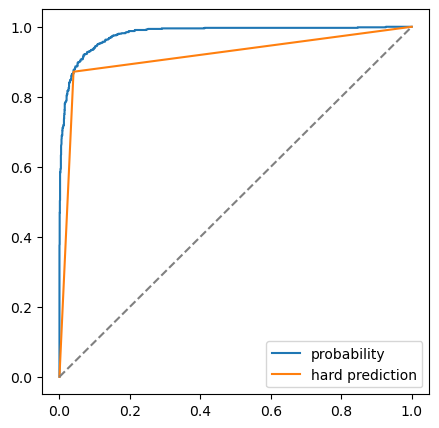

In [13]:
# INSPECTING THE ROC CURVE:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='probability')

fpr, tpr, _ = roc_curve(y_val, y_pred_bin)
plt.plot(fpr, tpr, label='hard prediction')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()
     

In [14]:
# CREATING CONFUSION MATRIX:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores


# IMPLEMENTATION OF FUNCTION:
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,654,1729,0,0
10,0.1,644,330,10,1399
20,0.2,623,201,31,1528
30,0.3,607,137,47,1592
40,0.4,592,104,62,1625
50,0.5,570,69,84,1660
60,0.6,550,50,104,1679
70,0.7,509,26,145,1703
80,0.8,467,17,187,1712
90,0.9,376,3,278,1726


In [15]:
# ADDING THE COLUMNS:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

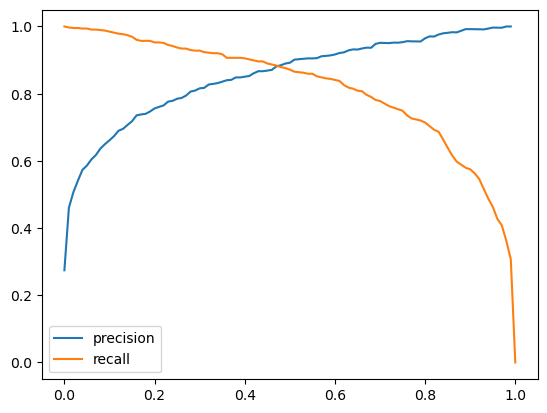

In [16]:
# INSPECTING THE CURVES:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()

### Answer for Q3 is around 0.48

In [17]:
# GETTING F1 SCORES:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

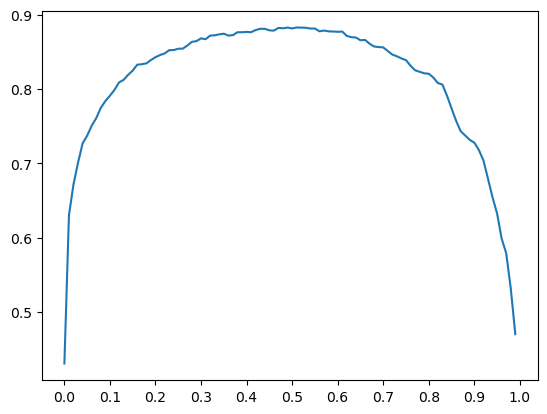

In [18]:
# INSPECTING F1 SCORE:
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

### Answer for Q4 is around 0.5

In [19]:
columns = categorical + numerical

In [20]:
# DEFINING TRAIN AND PREDICT FUNCTION:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [21]:
# INITIALIZING KFOLD CROSS VALIDATION:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average
    y_val = df_val.above_average

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.980 +- 0.003


In [22]:

# INSPECTING KFOLD CROSS VALIDATION:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 0.5, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average
        y_val = df_val.above_average

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.952 +- 0.002
C= 0.1, 0.972 +- 0.002
C= 0.5, 0.978 +- 0.001
C=  10, 0.982 +- 0.002
